In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os
import numpy as np
import matplotlib.pyplot as plt

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Constants for image size and batch processing
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 20

# Data augmentation
train_image_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Directory paths
train_dir = '/content/drive/MyDrive/Colab Notebooks/cats_and_dogs/train'
validation_dir = '/content/drive/MyDrive/Colab Notebooks/cats_and_dogs/validation'
test_dir = '/content/drive/MyDrive/Colab Notebooks/cats_and_dogs/test'

In [18]:
# 3
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data_gen = test_image_generator.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


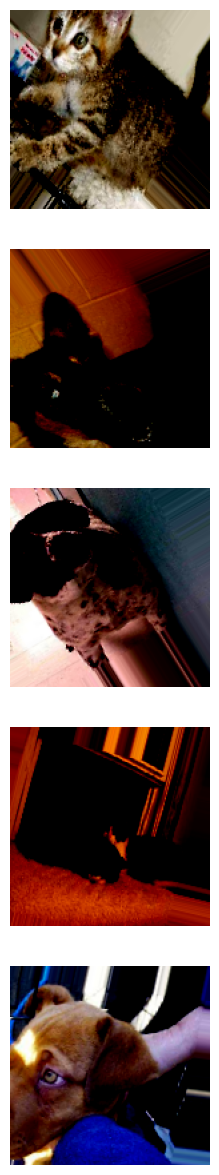

In [19]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Found 2000 images belonging to 2 classes.


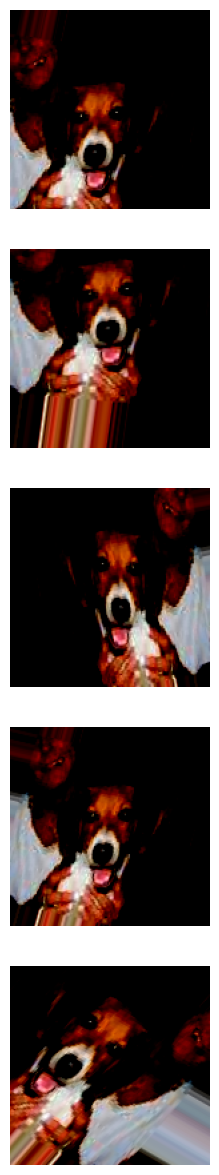

In [20]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [21]:
# Building the model using MobileNetV2
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                         

In [22]:
# Train the model
history = model.fit(
    x=train_data_gen,
    steps_per_epoch=train_data_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // BATCH_SIZE
)

Epoch 1/20
62/62 [==============================] - 82s 1s/step - loss: 0.3347 - accuracy: 0.8501 - val_loss: 0.1063 - val_accuracy: 0.9597
Epoch 2/20
62/62 [==============================] - 97s 2s/step - loss: 0.1976 - accuracy: 0.9182 - val_loss: 0.0925 - val_accuracy: 0.9667
Epoch 3/20
62/62 [==============================] - 83s 1s/step - loss: 0.1729 - accuracy: 0.9212 - val_loss: 0.0840 - val_accuracy: 0.9738
Epoch 4/20
62/62 [==============================] - 97s 2s/step - loss: 0.1817 - accuracy: 0.9284 - val_loss: 0.0895 - val_accuracy: 0.9677
Epoch 5/20
62/62 [==============================] - 95s 2s/step - loss: 0.1534 - accuracy: 0.9380 - val_loss: 0.0883 - val_accuracy: 0.9708
Epoch 6/20
62/62 [==============================] - 85s 1s/step - loss: 0.1375 - accuracy: 0.9421 - val_loss: 0.0760 - val_accuracy: 0.9738
Epoch 7/20
62/62 [==============================] - 100s 2s/step - loss: 0.1551 - accuracy: 0.9360 - val_loss: 0.0762 - val_accuracy: 0.9738
Epoch 8/20
62/62 [=

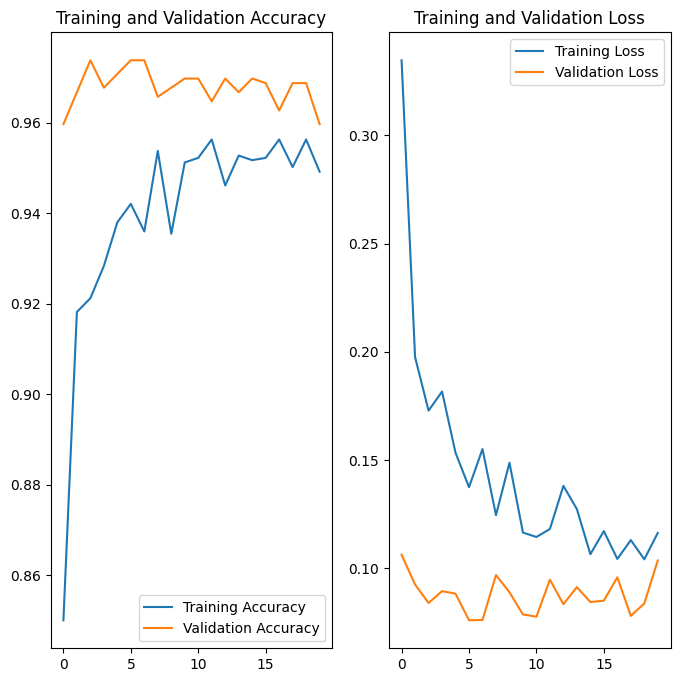

In [23]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2/2 [==============================] - 2s 244ms/step


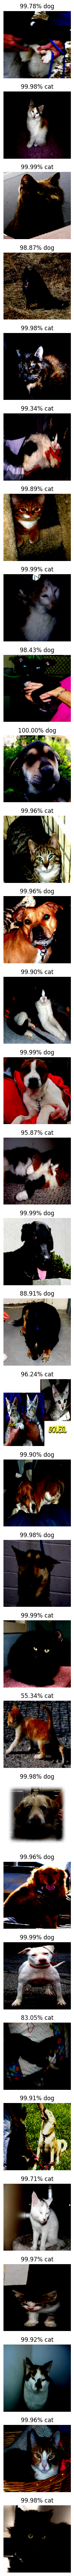

Your model correctly identified 96.0% of the images of cats and dogs.
You passed the challenge!


In [24]:
# Evaluate the model on test data
test_images, _ = next(test_data_gen)
probabilities = model.predict(test_data_gen)
probabilities = probabilities.flatten().tolist()
plotImages(test_images, probabilities)

answers = [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]
correct = sum([1 if round(prob) == answer else 0 for prob, answer in zip(probabilities, answers)])
percentage_identified = (correct / len(answers)) * 100

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")
if percentage_identified >= 70:
    print("You passed the challenge!")
else:
    print("You haven't passed yet. Your model should identify at least 70% of the images. Keep trying. You will get it!")